# MASS database inspection

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import sys

import ipywidgets as widgets
import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np
import pprint

detector_path = '..'
sys.path.append(detector_path)

from sleep.mass import MASS
from sleep.mass import KEY_EEG, KEY_PAGES, KEY_ID, KEY_MARKS
from sleep.data_ops import seq2inter, inter2seq, seq2inter_with_pages
from evaluation.metrics import by_sample_confusion, by_sample_iou, by_event_confusion, matching

%matplotlib inline

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
dataset = MASS(load_checkpoint=True)

Dataset mass with 14 patients.
Train size: 10. Test size: 4
Train subjects: 
 [1, 3, 5, 7, 9, 10, 11, 14, 17, 19]
Test subjects: 
 [2, 6, 12, 13]
Loading from checkpoint
Loaded


## Checking general numbers

In [ ]:
print('Sample frequency:', dataset.fs)
print('Page duration and size:', dataset.page_duration, dataset.page_size)
print('Registers ids:', dataset.all_ids)
print('Number of loaded registers:', len(dataset.data))
print('')
print('Train set IDs:', dataset.train_ids)
print('Test set IDs:', dataset.test_ids)

## Check one subject

In [ ]:
def plot_subject_global(signal, fs, pages, page_size, marks_1, marks_2):
    time_axis = np.arange(signal.size) / fs
    max_time = time_axis[-1]
    
    n_pages = np.ceil(signal.size / page_size).astype(int)
    n2_stages = np.zeros(n_pages, dtype=np.uint8)
    for page in pages:
        n2_stages[page] = 1
    
    marks_1_in_page = np.zeros(n_pages, dtype=np.int32)
    marks_2_in_page = np.zeros(n_pages, dtype=np.int32)
    marks_1_n2_without_marks = 0
    marks_2_n2_without_marks = 0
    marks_both_n2_without_marks = 0
    for page in pages:
        start_sample = page * page_size
        end_sample = (page+1) * page_size
        marks_1_presence = np.sum(marks_1[start_sample:end_sample])
        marks_2_presence = np.sum(marks_2[start_sample:end_sample])
        if marks_1_presence == 0:
            marks_1_n2_without_marks += 1
        if marks_2_presence == 0:
            marks_2_n2_without_marks += 1
        if marks_1_presence == 0 and marks_2_presence == 0:
            marks_both_n2_without_marks += 1
        marks_1_in_page[page] = marks_1_presence
        marks_2_in_page[page] = marks_2_presence
    
    print('Number of N2 pages without E1 marks: %d' % marks_1_n2_without_marks)
    print('Number of N2 pages without E2 marks: %d' % marks_2_n2_without_marks)
    print('Number of N2 pages without any marks: %d' % marks_both_n2_without_marks)
    
    fig, ax = plt.subplots(4, 1, figsize=(15, 7))
    
    ax[0].set_title('Normalized EEG Signal')
    ax[0].plot(time_axis, signal)
    ax[0].set_xlabel('Time [s]')
    ax[0].set_xlim([0, max_time])

    ax[1].set_title('N2 stages (white is active)')
    ax[1].imshow(n2_stages[np.newaxis, :], interpolation=None, aspect='auto', cmap='gray', extent=[0, max_time, 0, 1])
    ax[1].axis('off')
    
    ax[2].set_title('E1 marks presence (white is active)')
    ax[2].imshow(marks_1_in_page[np.newaxis, :], interpolation=None, aspect='auto', extent=[0, max_time, 0, 1], cmap='gray')
    ax[2].axis('off')
    
    ax[3].set_title('E2 marks presence (white is active)')
    ax[3].imshow(marks_2_in_page[np.newaxis, :], interpolation=None, aspect='auto', extent=[0, max_time, 0, 1], cmap='gray')
    ax[3].axis('off')
    
    plt.tight_layout()
    plt.show()

### Complete register visualization

In [ ]:
# Registers ids: [1, 2, 3, 5, 6, 7, 9, 10, 11, 12, 13, 14, 17, 19]
subject_id = 1

In [ ]:
ind_idx = dataset.all_ids.index(subject_id)
ind_dict = dataset.data[ind_idx]
subject_id = ind_dict[KEY_ID]
signal = ind_dict[KEY_EEG]
pages = ind_dict[KEY_PAGES]
marks_1 = ind_dict['%s_1' % KEY_MARKS]
marks_2 = ind_dict['%s_2' % KEY_MARKS]

print('Loaded subject ID %s' % subject_id)
print('Signal size %d. Number of pages %d' % (signal.shape[0], pages.shape[0]))

In [ ]:
plot_subject_global(signal, dataset.fs, pages, dataset.page_size, marks_1, marks_2)

## Marks statistics from saved data

In [ ]:
marks_1_stamps = seq2inter(marks_1)
marks_2_stamps = seq2inter(marks_2)
print('Number of marks from E1: %d' % marks_1_stamps.shape[0])
print('Number of marks from E2: %d' % marks_2_stamps.shape[0])

In [ ]:
durations_1 = np.diff(marks_1_stamps)[:, 0] / dataset.fs
durations_2 = np.diff(marks_2_stamps)[:, 0] / dataset.fs

fig, ax = plt.subplots(2, 1, sharex=True)
ax[0].hist(durations_1, bins=20)
ax[0].set_title('E1 marks durations')
ax[1].hist(durations_2, bins=20)
ax[1].set_title('E2 marks durations')
ax[1].set_xlabel('Duration [s]')
plt.show()

In [ ]:
# Compute statistics comparing E1 and E2

# By sample
print('By Sample Stats between E1 and E2:')
bs_metrics = by_sample_confusion(marks_1, marks_2, input_is_binary=True)
bs_iou = by_sample_iou(marks_1, marks_2, input_is_binary=True)
print('BS IoU: %1.4f' % bs_iou)
pprint.pprint(bs_metrics)

# By event
print('\nBy Event stats between E1 and E2:')
print('Number of marks from E1: %d' % marks_1_stamps.shape[0])
print('Number of marks from E2: %d' % marks_2_stamps.shape[0])
iou_array, idx_e2_marks = matching(marks_1_stamps, marks_2_stamps)
nonzero_iou_array = iou_array[iou_array > 0]
print('Number of nonzero iou marks:', nonzero_iou_array.shape[0])
be_metrics = by_event_confusion(marks_1_stamps, marks_2_stamps, iou_array=iou_array)
pprint.pprint(be_metrics)

In [ ]:
fig = plt.figure(figsize=(10,2))
plt.hist(nonzero_iou_array, bins=[i*0.1 for i in range(11)])
plt.xlabel('IoU')
plt.title('NonZero IoU between E1 and E2 (mean %1.4f)' % be_metrics['mean_nonzero_iou'])
plt.show()

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)

ax[0].set_title('E1 marks')
ax[0].scatter(durations_1, iou_array, alpha=0.3)
ax[0].set_xlabel('Duration [s]')
ax[0].set_ylabel('IoU')

iou_array_e2 = np.zeros(durations_2.shape)
for i, idx in enumerate(idx_e2_marks):
    if idx != -1:
        iou_array_e2[idx] = iou_array[i]

ax[1].set_title('E2 marks')
ax[1].scatter(durations_2, iou_array_e2, alpha=0.3)
ax[1].set_xlabel('Duration [s]')

plt.tight_layout()
plt.show()

In [ ]:
durations_2_matched = np.zeros(durations_1.shape)
for i, idx in enumerate(idx_e2_marks):
    if idx != -1:
        durations_2_matched[i] = durations_2[idx]
        
plt.title('Durations of matched events')
plt.scatter(durations_1, durations_2_matched, alpha=0.3)
plt.plot([0, 3], [0, 3])
plt.xlabel('E1 duration [s]')
plt.ylabel('E2 duration [s]')
plt.xlim([0, 3])
plt.ylim([0, 3])
plt.axis('square')
plt.show()

## Page visualization

In [ ]:
n2_signal, n2_marks_1 = dataset.get_subject_data(subject_id, which_expert=1, verbose=True)
_, n2_marks_2 = dataset.get_subject_data(subject_id, which_expert=2, verbose=True)
pages = dataset.get_subject_pages(subject_id)

In [ ]:
print('Number of n2 pages:', n2_signal.shape)
tmp = np.sum(n2_marks_1, axis=1)
tmp = sum((tmp==0).astype(int))
print('Number of pages without E1 marks:', tmp)
tmp = np.sum(n2_marks_2, axis=1)
tmp = sum((tmp==0).astype(int))
print('Number of pages without E2 marks:', tmp)

In [ ]:
n2_marks_1_stamps = seq2inter_with_pages(n2_marks_1, pages)
n2_marks_2_stamps = seq2inter_with_pages(n2_marks_2, pages)
print('Number of E1 marks:', n2_marks_1_stamps.shape)
print('Number of E2 marks:', n2_marks_2_stamps.shape)

In [ ]:
def plot_page(page, signal, e1_marks, e2_marks, n2_pages, fs):
    fig = plt.figure(figsize=(20, 6)) 
    gs = gridspec.GridSpec(3, 1, height_ratios=[4, 1, 1]) 
    
    page = page - 1
    
    segment_signal = signal[page, :]
    segment_e1_marks = e1_marks[page, :]
    segment_e2_marks = e2_marks[page, :]
    time_axis = np.arange(signal.shape[1])/fs
    
    # Signal
    ax0 = fig.add_subplot(gs[0])
    ax0.plot(time_axis, segment_signal)
    ax0.set_yticks([])
    ax0.set_xlim([0, 20])
    ax0.set_ylim([-6, 6])
    ax0.set_title('EEG Signal, C3-CLE (intervals of 0.5s are shown), original page %d' % n2_pages[page])
    ax0.set_xticks([0, 5, 10, 15, 20])
    ax0.set_xticks(np.arange(0, 20, 0.5), minor=True)
    ax0.grid(b=True, axis='x', which='minor')
    
    # Expert mark
    ax2 = fig.add_subplot(gs[1])
    ax2.imshow(segment_e1_marks[np.newaxis, :], interpolation=None, aspect='auto', cmap='gray')
    ax2.axis('off')
    ax2.set_title('Expert 1 (white is active)')
    
    ax3 = fig.add_subplot(gs[2])
    ax3.imshow(segment_e2_marks[np.newaxis, :], interpolation=None, aspect='auto', cmap='gray')
    ax3.axis('off')
    ax3.set_title('Expert 2 (White is active)')
    
    plt.tight_layout()
    plt.show()

In [ ]:
widgets.interact(
    lambda page: plot_page(page, n2_signal, n2_marks_1, n2_marks_2, pages, dataset.fs),
    page=widgets.IntSlider(min=1,max=n2_signal.shape[0],step=1,value=1, continuous_update=False));

## Spindle Activity Distribution across training examples

In [26]:
# Load all training pages

# Get training set ids
print('Loading training set and splitting')
all_train_ids = dataset.train_ids
# We won't split train intro train and val sets, it doesn't matter

# Get data
# We don't add border nor augment pages to don't perturb spindle activity INSIDE the page
_, y_train_1 = dataset.get_subset_data(
    all_train_ids, augmented_page=False, border_size=0,
    which_expert=1, verbose=False)
_, y_train_2 = dataset.get_subset_data(
    all_train_ids, augmented_page=False, border_size=0,
    which_expert=2, verbose=False)
print('Pages loaded')
    
# Now count samples with spindle activity
activity_train_1 = []
for sub_marks in y_train_1:
    this_activity = np.sum(sub_marks, axis=1)
    activity_train_1.append(this_activity)
    print(this_activity.shape)
activity_train_2 = []
for sub_marks in y_train_2:
    this_activity = np.sum(sub_marks, axis=1)
    activity_train_2.append(this_activity)
    print(this_activity.shape)  
# Now concatenate everything
all_activity_train_1 = np.concatenate(activity_train_1, axis=0)
all_activity_train_2 = np.concatenate(activity_train_2, axis=0)
print('All train pages:', all_activity_train_1.shape)
print('All train pages:', all_activity_train_2.shape)

Loading training set and splitting
Pages loaded
(745,)
(496,)
(633,)
(694,)
(739,)
(696,)
(638,)
(730,)
(797,)
(804,)
(745,)
(496,)
(633,)
(694,)
(739,)
(696,)
(638,)
(730,)
(797,)
(804,)
All train pages: (6972,)
All train pages: (6972,)


--------------
Expert 1 Stats
--------------
Number of pages: 6972
Number of zero activity pages: 3355 (48.1211% of training set)
Mean nonzero activity: 285
Median nonzero activity: 227
Max nonzero activity: 1167
Median of all activity: 106
--------------
Expert 2 Stats
--------------
Number of pages: 6972
Number of zero activity pages: 1295 (18.5743% of training set)
Mean nonzero activity: 624
Median nonzero activity: 554
Max nonzero activity: 2266
Median of all activity: 429


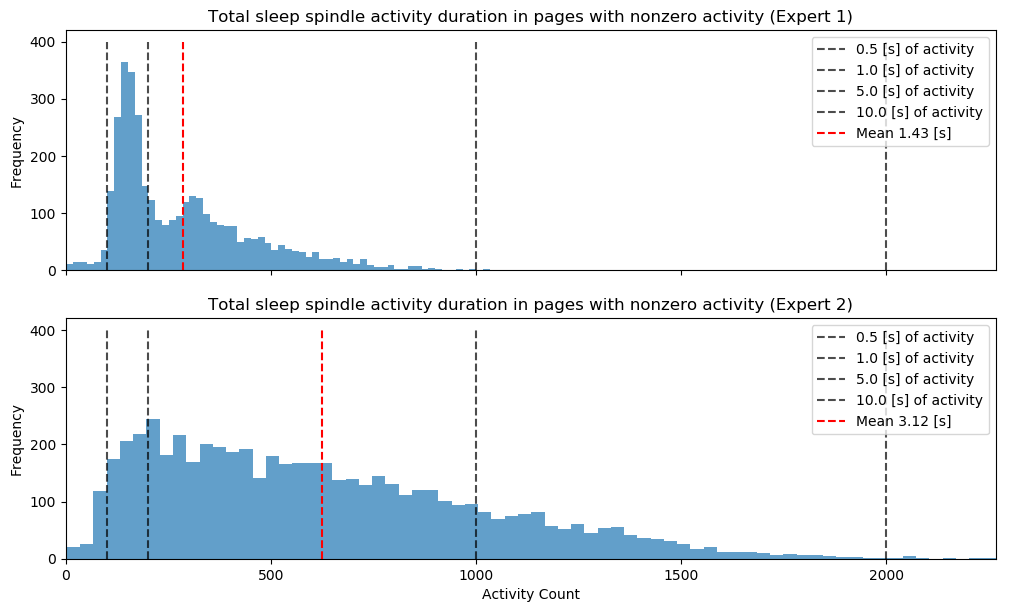

In [74]:
ntotal = all_activity_train_1.size
nzero_1 = np.where(all_activity_train_1==0)[0].size
nzero_2 = np.where(all_activity_train_2==0)[0].size
nonzero_activity_train_1 = all_activity_train_1[np.where(all_activity_train_1>0)]
nonzero_activity_train_2 = all_activity_train_2[np.where(all_activity_train_2>0)]

print('--------------')
print('Expert 1 Stats')
print('--------------')
print('Number of pages:', ntotal)
print('Number of zero activity pages:', nzero_1, '(%1.4f%% of training set)' % (100*nzero_1 / ntotal))
mean_1 = np.mean(nonzero_activity_train_1)
print('Mean nonzero activity: %1.0f' %  mean_1)
print('Median nonzero activity: %1.0f' %  np.median(nonzero_activity_train_1))
print('Max nonzero activity: %1.0f' %  np.max(nonzero_activity_train_1))
print('Median of all activity: %1.0f' % np.median(all_activity_train_1))

print('--------------')
print('Expert 2 Stats')
print('--------------')
print('Number of pages:', ntotal)
print('Number of zero activity pages:', nzero_2, '(%1.4f%% of training set)' % (100*nzero_2 / ntotal))
mean_2 = np.mean(nonzero_activity_train_2)
print('Mean nonzero activity: %1.0f' %  mean_2)
print('Median nonzero activity: %1.0f' %  np.median(nonzero_activity_train_2))
print('Max nonzero activity: %1.0f' %  np.max(nonzero_activity_train_2))
print('Median of all activity: %1.0f' % np.median(all_activity_train_2))

fs = 200

second_marks = [0.5, 1, 5, 10]
max_value = 400
bins = 70

fig, ax = plt.subplots(2, 1, dpi=100, figsize=(12, 7), sharex=True)
ax[0].hist(nonzero_activity_train_1, bins=bins, alpha=0.7)
ax[0].set_title('Total sleep spindle activity duration in pages with nonzero activity (Expert 1)')
ax[0].set_ylabel('Frequency')

for second in second_marks:
    ax[0].plot([second*fs, second*fs], [0, max_value], 'k--', label='%1.1f [s] of activity' % second, alpha=0.7)

ax[0].plot([mean_1, mean_1], [0, max_value], 'r--', label='Mean %1.2f [s]' % (mean_1/fs))
    
ax[0].legend(loc='upper right')

ax[1].hist(nonzero_activity_train_2, bins=bins, alpha=0.7)
ax[1].set_title('Total sleep spindle activity duration in pages with nonzero activity (Expert 2)')
ax[1].set_xlabel('Activity Count')
ax[1].set_ylabel('Frequency')

for second in second_marks:
    ax[1].plot([second*fs, second*fs], [0, max_value], 'k--', label='%1.1f [s] of activity' % second, alpha=0.7)

ax[1].plot([mean_2, mean_2], [0, max_value], 'r--', label='Mean %1.2f [s]' % (mean_2/fs))
    
ax[1].legend(loc='upper right')
ax[1].set_xlim([0, np.max(nonzero_activity_train_2)])

plt.show()